In [124]:
from collections import defaultdict
import string
import glob
import numpy as np
import pickle

import matplotlib.pyplot as plt

from keras.applications import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model, load_model

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import image
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dropout, Dense, Embedding, LSTM
from keras.layers import add

In [2]:
def load_doc(file_name):
    file = open(file_name, 'r')
    text = file.read()
    file.close()
    return text
file_name = "G:\Lesson\DeepLearningCourseProjects\Image_Captioning\Flickr_Data\Flickr_TextData/Flickr8k.token.txt"
doc = load_doc(file_name)

In [3]:
print(doc[:1000])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg#0	A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg#1	A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg#2	A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg#3	Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg#4	Two dogs on pavement moving toward each other .
1002674143_1b742ab4b8.jpg#0	A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
1002674143_1b

In [4]:
# each file has 5 captions
def load_descriptions(doc):
    mapping = defaultdict(list)
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split('\t')
        if len(tokens) < 2:
            continue
        image_id, image_description = tokens
        image_id = image_id.split('.')[0]
        
        mapping[image_id].append(image_description)
    return mapping
descriptions = load_descriptions(doc)
print(f'Loaded: {len(descriptions)}')

        

Loaded: 8092


In [5]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [6]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

### Data Cleaning

In [7]:
def clean_descriptions(descriptions):
    table = str.maketrans('','', string.punctuation)
    for id_, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            desc = desc.split()
            desc = [w.lower() for w in desc]
            desc = [w for w in desc if len(w)>1]
            desc = [w for w in desc if w.isalpha()]
            # we can get rid of stop words too
            desc_list[i] = ' '.join(desc)
clean_descriptions(descriptions)

In [8]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [9]:
def to_vocabulary(descriptions):
    vocabularies = set()
    for _, desc_list in descriptions.items():
        [vocabularies.update(desc.split()) for desc in desc_list]
    return vocabularies
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: ', len(vocabulary))

Original Vocabulary Size:  8357


In [10]:
def save_descriptions(descriptions, file_name):
    lines = list()
    for key, desc_list in descriptions.items():
        [lines.append(key + '\t' + desc)  for desc in desc_list]
    data = '\n'.join(lines)
    file = open(file_name, 'w')
    file.write(data)
    file.close()
save_descriptions(descriptions, file_name='descriptions.txt')

### Loading the training set

In [11]:
images = ".\Flickr_Data\Images/"
img = glob.glob(images + '*.jpg')
img

['.\\Flickr_Data\\Images\\1000268201_693b08cb0e.jpg',
 '.\\Flickr_Data\\Images\\1001773457_577c3a7d70.jpg',
 '.\\Flickr_Data\\Images\\1002674143_1b742ab4b8.jpg',
 '.\\Flickr_Data\\Images\\1003163366_44323f5815.jpg',
 '.\\Flickr_Data\\Images\\1007129816_e794419615.jpg',
 '.\\Flickr_Data\\Images\\1007320043_627395c3d8.jpg',
 '.\\Flickr_Data\\Images\\1009434119_febe49276a.jpg',
 '.\\Flickr_Data\\Images\\1012212859_01547e3f17.jpg',
 '.\\Flickr_Data\\Images\\1015118661_980735411b.jpg',
 '.\\Flickr_Data\\Images\\1015584366_dfcec3c85a.jpg',
 '.\\Flickr_Data\\Images\\101654506_8eb26cfb60.jpg',
 '.\\Flickr_Data\\Images\\101669240_b2d3e7f17b.jpg',
 '.\\Flickr_Data\\Images\\1016887272_03199f49c4.jpg',
 '.\\Flickr_Data\\Images\\1019077836_6fc9b15408.jpg',
 '.\\Flickr_Data\\Images\\1019604187_d087bf9a5f.jpg',
 '.\\Flickr_Data\\Images\\1020651753_06077ec457.jpg',
 '.\\Flickr_Data\\Images\\1022454332_6af2c1449a.jpg',
 '.\\Flickr_Data\\Images\\1022454428_b6b660a67b.jpg',
 '.\\Flickr_Data\\Images\\1022

In [12]:
train_images_file = 'G:\Lesson\DeepLearningCourseProjects\Image_Captioning\Flickr_Data\Flickr_TextData\Flickr_8k.trainImages.txt'
test_images_file = 'G:\Lesson\DeepLearningCourseProjects\Image_Captioning\Flickr_Data\Flickr_TextData\Flickr_8k.testImages.txt'
dev_images_file = 'G:\Lesson\DeepLearningCourseProjects\Image_Captioning\Flickr_Data\Flickr_TextData\Flickr_8k.devImages.txt'

def get_image_file(image_file, img, images, set_images):
    train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
    images_items = []
    for i in img:
        if i[len(images):] in set_images:
            images_items.append(i)
    return images_items    

train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))
dev_images = set(open(dev_images_file, 'r').read().strip().split('\n'))

train_img = get_image_file(train_images, img, images, train_images)
test_img = get_image_file(test_images, img, images, test_images)
dev_img = get_image_file(dev_images, img, images, dev_images)

In [13]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# # load training dataset (6K)
train = load_set(train_images_file)
test = load_set(test_images_file)
dev = load_set(dev_images_file)
print('train Dataset: %d' % len(train))
print('test Dataset: %d' % len(test))
print('dev Dataset: %d' % len(dev))

train Dataset: 6000
test Dataset: 1000
dev Dataset: 1000


In [14]:
def load_clean_descriptions(file_name, dataset):
    doc = load_doc(file_name)
    descriptions = defaultdict(list)
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split('\t')
        image_id, desc = tokens
        image_id = image_id.split('.')[0]
        if image_id in dataset:
            desc = 'startseq ' + ''.join(desc) + ' endseq'
            descriptions[image_id].append(desc)
    return descriptions


# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
dev_descriptions = load_clean_descriptions('descriptions.txt', dev)
print('Descriptions: dev=%d' % len(dev_descriptions))

Descriptions: train=6000
Descriptions: test=1000
Descriptions: dev=1000


In [15]:
dev_descriptions

defaultdict(list,
            {'1022454332_6af2c1449a': ['startseq child and woman are at waters edge in big city endseq',
              'startseq large lake with lone duck swimming in it with several people around the edge of it endseq',
              'startseq little boy at lake watching duck endseq',
              'startseq young boy waves his hand at the duck in the water surrounded by green park endseq',
              'startseq two people are at the edge of lake facing the water and the city skyline endseq'],
             '103106960_e8a41d64f8': ['startseq boy with stick kneeling in front of goalie net endseq',
              'startseq child in red jacket playing street hockey guarding goal endseq',
              'startseq young kid playing the goalie in hockey rink endseq',
              'startseq young male kneeling in front of hockey goal with hockey stick in his right hand endseq',
              'startseq hockey goalie boy in red jacket crouches by goal with stick endseq'],
   

### Data Preprocessing - Images

In [25]:
model = InceptionV3(weights='imagenet')

In [26]:
# model.save_weights('inceptions.h5')
model_new= Model(model.input, model.layers[-2].output)

In [27]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [60]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image)
    fea_vec = fea_vec.reshape((-1,))
    return fea_vec

def get_encoded(set_img):
    print('number which needs to be processed: ', len(set_img))
    encoding = dict()
    for i, img in enumerate(set_img):
        encoding[img[len(images):]]= encode(img)
#         print('step ', i, img[len(images):], ' done')
    return encoding

def save_encoded(encoding, file_address):
    with open(file_address, 'wb') as encoded_pickle:
        pickle.dump(encoding, encoded_pickle)

def load_features(file_address):
    with open(file_address,'rb') as file:
        set_features = pickle.load(file)
    print('Photos: %d' % len(set_features))
    return set_features


In [40]:
train_pickle_address = './encoded_train_images.pkl'   
test_pickle_address = './encoded_test_images.pkl' 
dev_pickle_address = './encoded_dev_images.pkl' 

In [52]:
train_encoding = get_encoded(train_img)
save_encoded(train_encoding, train_pickle_address)
train_features = load_features(train_pickle_address)

number which needs to be processed:  6000
Photos: 6000


In [53]:
test_encoding = get_encoded(test_img)
save_encoded(test_encoding, test_pickle_address)
test_features = load_features(test_pickle_address)

number which needs to be processed:  1000
Photos: 1000


In [54]:
dev_encoding = get_encoded(dev_img)
save_encoded(dev_encoding, dev_pickle_address)
dev_features = load_features(dev_pickle_address)

number which needs to be processed:  1000
Photos: 1000


In [57]:
def get_all_captions(set_descriptions):
    all_set_captions = []
    for key, val in set_descriptions.items():
        all_set_captions.extend(val)
    print(len(all_set_captions))
    return all_set_captions

In [59]:
all_train_captions =  get_all_captions(train_descriptions)
all_test_captions =  get_all_captions(test_descriptions)
all_dev_captions =  get_all_captions(dev_descriptions)

30000
5000
5000


### Data Preprocessing - Captions

In [69]:
# Consider only words which occur at least 10 times in the corpus
def take_frequents(all_set_captions):
    word_count_threshold = 10
    word_counts = defaultdict(int)
    for sentence in all_set_captions:
        for word in sentence.split():
            word_counts[word] += 1
    vocab = [word for word, count in word_counts.items() if count >= word_count_threshold]
    print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))
    return vocab
vocab = take_frequents(all_train_captions)

preprocessed words 7265 -> 1643


In [71]:
def create_word_to_index(vocabulary):
    word_to_index = dict()
    index_to_word = dict()
    for index, word in enumerate(vocabulary, 1):
        word_to_index[word] =  index
        index_to_word[index] = word
    return word_to_index, index_to_word
word_to_index, index_to_word = create_word_to_index(vocab)

In [72]:
vocab_size = len(index_to_word) + 1 # one for appended 0's
vocab_size

1644

In [83]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    [all_desc.extend(val) for val  in descriptions.values()]
    return all_desc
# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(desc.split()) for desc in lines)
max_length = max_length(train_descriptions)
print('Max Description Length: %d' % max_length)

Max Description Length: 33


### Data Preparation using Generator Function

In [118]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, word_to_index, max_length, num_photos_per_batch):
    n = 0
    x_1, x_2, y = [], [], []
    
    # loop for ever over images
    while True:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve teh photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [word_to_index[word] for word in desc.split() if word in word_to_index]
                # split one sequence into multiple x, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length, padding='pre')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store
                    x_1.append(photo)
                    x_2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[np.array(x_1), np.array(x_2)], np.array(y)]
                x_1, x_2, y = [], [], []
                n = 0

### Word Embeddings

In [101]:
glove_address = 'glove.6B.200d.txt'
def get_glove(file_address):
    embedding_index = {}
    file = open(glove_address, 'r', encoding='utf-8')
    for line in file.readlines():
        values = line.split()
        word = values[0]
        coefs = np.array(values[1:], dtype='float32')
        embedding_index[word] = coefs
    file.close()
    print('Found %s word vectors.' % len(embeddings_index))
    return embedding_index
embedding_index = get_glove(glove_address)

Found 400000 word vectors.


In [102]:
embedding_dim = 200
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, index in word_to_index.items():
    vector = embedding_index.get(word)
    if vector is not None :
        embedding_matrix[index] = vector

### Model Architecture

In [128]:
inputs_1 = Input(shape=(2048,))
x = inputs_1
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)

inputs_2 = Input(shape=(max_length, ))
y = inputs_2
y = Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False, mask_zero=True)(y)
y = Dropout(0.5)(y)
y = LSTM(256)(y)

z = add([x, y])
z = Dense(256, activation='relu')(z)
outputs = Dense(vocab_size, activation='softmax')(z)
model = Model([inputs_1, inputs_2], outputs=outputs)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           (None, 33)           0                                            
__________________________________________________________________________________________________
input_9 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 33, 200)      328800      input_10[0][0]                   
__________________________________________________________________________________________________
dropout_6 (Dropout)             (None, 2048)         0           input_9[0][0]                    
__________________________________________________________________________________________________
dropout_7 

In [129]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam')

In [130]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

for i in range(epochs):
    print('Epoch: ', i + 1)
    generator = data_generator(train_descriptions, train_features, word_to_index,max_length,number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
model.save('model_' + str(i) + '.h5')

Epoch:  1
Epoch 1/1
2000/2000 [==============================] - 111s 56ms/step - loss: 4.1195
Epoch:  2
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 3.4259
Epoch:  3
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 3.2073
Epoch:  4
Epoch 1/1
2000/2000 [==============================] - 107s 54ms/step - loss: 3.0756
Epoch:  5
Epoch 1/1
2000/2000 [==============================] - 107s 53ms/step - loss: 2.9797
Epoch:  6
Epoch 1/1
2000/2000 [==============================] - 107s 54ms/step - loss: 2.9098
Epoch:  7
Epoch 1/1
2000/2000 [==============================] - 107s 54ms/step - loss: 2.8510
Epoch:  8
Epoch 1/1
2000/2000 [==============================] - 107s 54ms/step - loss: 2.8034
Epoch:  9
Epoch 1/1
2000/2000 [==============================] - 107s 54ms/step - loss: 2.7625
Epoch:  10
Epoch 1/1
2000/2000 [==============================] - 107s 53ms/step - loss: 2.7301


In [131]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

for i in range(epochs):
    print('Epoch: ', i + 1)
    generator = data_generator(train_descriptions, train_features, word_to_index,max_length,number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
model.save('model_' + str(i + 11) + '.h5')

Epoch:  1
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 2.6989
Epoch:  2
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 2.6722
Epoch:  3
Epoch 1/1
2000/2000 [==============================] - 107s 53ms/step - loss: 2.6478
Epoch:  4
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 2.6288
Epoch:  5
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 2.6114
Epoch:  6
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 2.5932
Epoch:  7
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 2.5785
Epoch:  8
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 2.5630
Epoch:  9
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 2.5511
Epoch:  10
Epoch 1/1
2000/2000 [==============================] - 108s 54ms/step - loss: 2.5378


In [133]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

for i in range(epochs):
    print('Epoch: ', i + 1)
    generator = data_generator(train_descriptions, train_features, word_to_index, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
model.save_weights('model_30.h5')

Epoch:  1
Epoch 1/1
1000/1000 [==============================] - 57s 57ms/step - loss: 2.4952
Epoch:  2
Epoch 1/1
1000/1000 [==============================] - 57s 57ms/step - loss: 2.4761
Epoch:  3
Epoch 1/1
1000/1000 [==============================] - 58s 58ms/step - loss: 2.4658
Epoch:  4
Epoch 1/1
1000/1000 [==============================] - 59s 59ms/step - loss: 2.4553
Epoch:  5
Epoch 1/1
1000/1000 [==============================] - 57s 57ms/step - loss: 2.4438
Epoch:  6
Epoch 1/1
1000/1000 [==============================] - 57s 57ms/step - loss: 2.4345
Epoch:  7
Epoch 1/1
1000/1000 [==============================] - 57s 57ms/step - loss: 2.4241
Epoch:  8
Epoch 1/1
1000/1000 [==============================] - 57s 57ms/step - loss: 2.4151
Epoch:  9
Epoch 1/1
1000/1000 [==============================] - 57s 57ms/step - loss: 2.4081
Epoch:  10
Epoch 1/1
1000/1000 [==============================] - 57s 57ms/step - loss: 2.3986


In [134]:
def greedy_search(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [word_to_index[w] for w in in_text.split() if w in word_to_index]
        sequence = pad_sequences([sequence], maxlen=max_length)
        y_hat = model.predict([photo,sequence], verbose=0)
        y_hat = np.argmax(y_hat)
        word = index_to_word[y_hat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

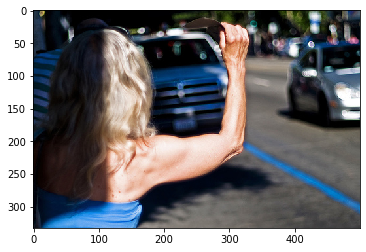

Greedy: woman in black and white uniform walks down the street


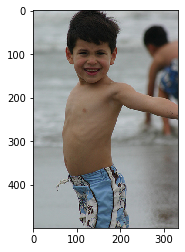

Greedy: young boy in swimming pool


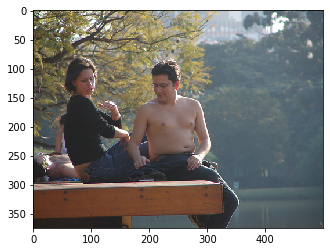

Greedy: man in red shirt is sitting on the grass


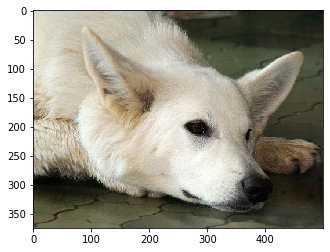

Greedy: dog is running on the grass


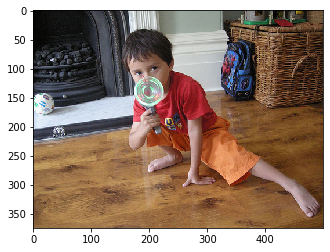

Greedy: two little girls are sitting on the grass


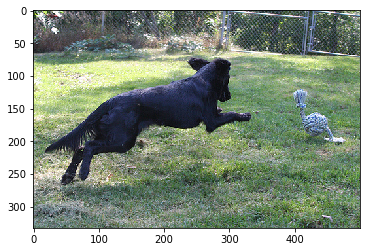

Greedy: black dog is running through field of grass


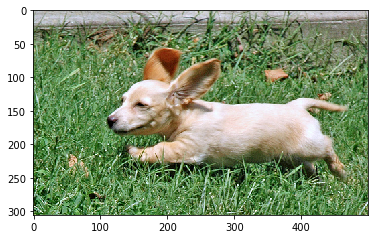

Greedy: two dogs are playing tug of war with their string


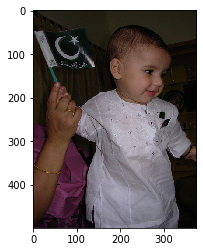

Greedy: little boy with his mouth open and his mouth open and tongue out


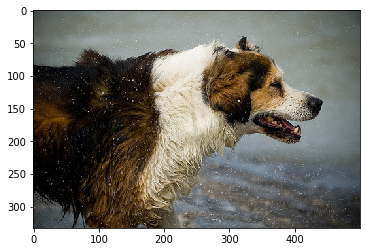

Greedy: dog is running through the water


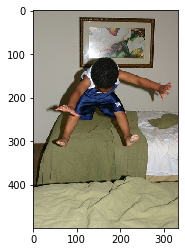

Greedy: two little boys are sitting on giant bed


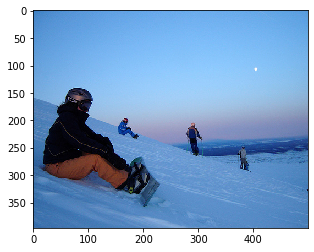

Greedy: man in red hat is sitting on the snow


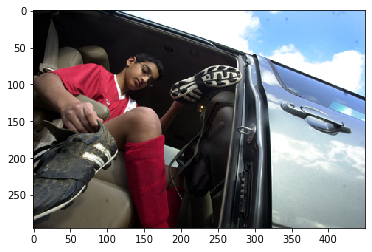

Greedy: man in black hat and hat is riding bike in traffic


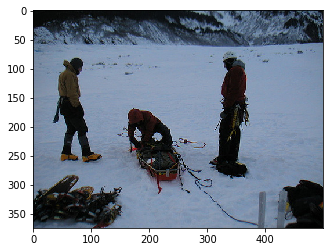

Greedy: two people are walking through deep snow


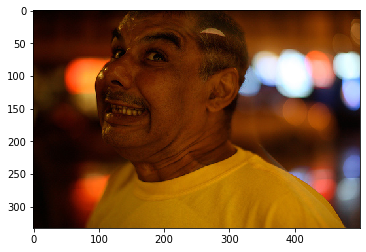

Greedy: man with glasses and glasses is standing in front of crowd


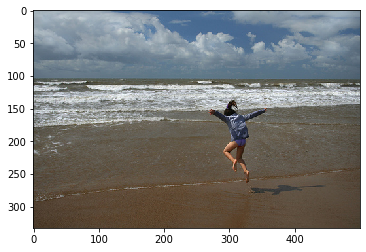

Greedy: young boy running on the beach


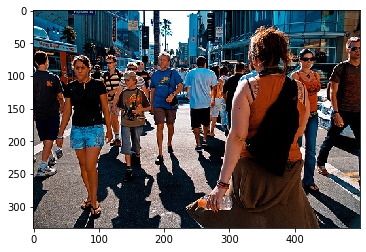

Greedy: woman in black walks down city street


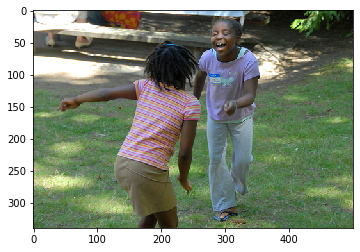

Greedy: little girl in pink dress is jumping on the grass


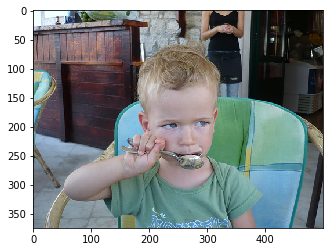

Greedy: little boy is playing with hay


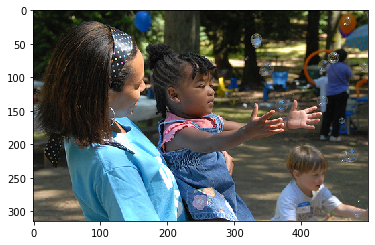

Greedy: little girl in pink tutu dances


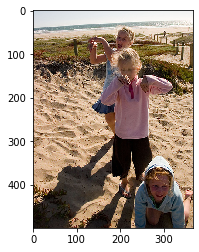

Greedy: little girl in swimsuit jumps into the water


In [135]:
for z in range(20):
    pic = list(test_encoding.keys())[z]
    image = test_encoding[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedy_search(image))

<a href='https://towardsdatascience.com/image-captioning-with-keras-teaching-computers-to-describe-pictures-c88a46a311b8'>source code</a>

*:)*